In [135]:
# array[100] -> array[100]
# Can we learn a function to transform a whole timeseries into another timeseries?
# rather than point by point, go from x[100] points to y[100] points.

# function is simple y=-1 where x & y are arrays

# works, and accuracy is functional. Why does it plateau?

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

# might need to comment this out if you don't have a GPU
# perhaps unecessary in general, but I haven't found a way to make it work!
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

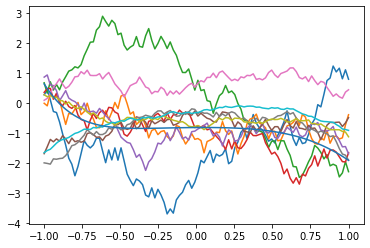

In [87]:
def gen_rand_poly(N, K=7):
    xs = np.linspace(-1.0, 1.0, N)
    coeffs = np.array([np.random.uniform(-1.0, 1.0) for _ in range(K)])
    ys = np.polynomial.polynomial.polyval(xs, coeffs)
    return ys

def gen_random_func(N):
    return (np.random.random(N)-0.5).cumsum()

def gen_random_seq(N, a=0.5):
    return a * gen_rand_poly(N) + (1.0 - a) * gen_random_func(N)

for a in np.arange(0.0, 1.1, 0.1):
    ys = gen_random_seq(N, a)
    plt.plot(xs, ys)

# examine examples, should see some smooth, some noisy

((2000, 100), (2000, 100))

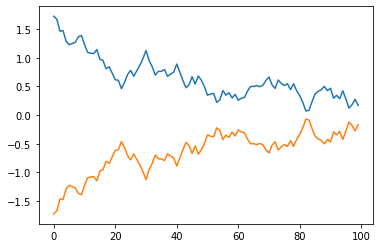

In [102]:
# generate train / test set
# "mirror" fn around x-axis, i.e. y=+1.0 becomes y=-1.0
xs = [gen_random_seq(100, random.random()) for _ in range(2000)]
xs = np.array(xs)
ys = xs * -1.0

# show that ys is xs mirrored
plt.plot(xs[0])
plt.plot(ys[0])

xs.shape, ys.shape

In [105]:
# train / test split
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1340, 100), (1340, 100), (660, 100), (660, 100))

In [110]:
def plot_training_history(history, model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()
    
    loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
    print(f'Test loss: {loss:.3}')

    print(f'Test accuracy: {accuracy:.3}')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 200)               20200     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               10100     
Total params: 50,400
Trainable params: 50,400
Non-trainable params: 0
_________________________________________________

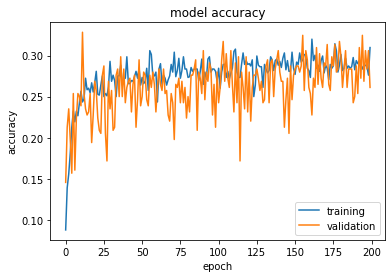

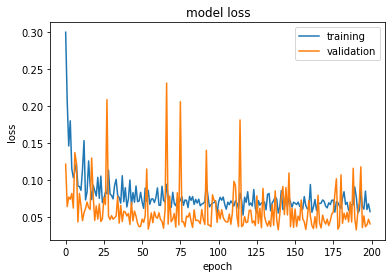

Test loss: 0.0428
Test accuracy: 0.282


In [134]:
from tensorflow.keras.callbacks import Callback
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print('{:d}/{:.4f}/{:.4f}/{:.4f}/{:.4f} '.format(epoch, logs['loss'], logs['accuracy'], 
                logs['val_loss'], logs['val_accuracy']), end='')

K = len(x_train[0])

test_data = x_test
test_labels = y_test

model = Sequential()
model.add(Input(shape=(K,)))
model.add(Dense(units=K*2, activation='linear'))
model.add(LeakyReLU(alpha=0.03))
model.add(Dense(units=K, activation='linear'))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(units=K, activation='linear'))

model.summary()

model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
history = model.fit(x_train, y_train, shuffle=True, batch_size=1, epochs=200, verbose=0, validation_split=.2, callbacks=[MyCallback()])
plot_training_history(history, model)

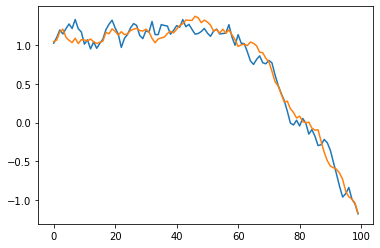

In [136]:
# hmm ish
yhat = model.predict(x_test[0].reshape(1, -1)).reshape(-1, )
plt.plot(x_test[0])

# invert to make checking easier
_ = plt.plot(yhat*-1.0)